# Tutorial

First we'll import all required libraries

In [26]:
import sys
sys.path.append('/home/ubuntu/tormography/src')
from pytomography.algorithms.osem import OSEMNet, get_osem_net
from pytomography.projections import ForwardProjectionNet, BackProjectionNet
from pytomography.io import simind_projections_to_data
import numpy as np
import matplotlib.pyplot as plt
import torch

Just like in regular PyTorch, we choose our computation device.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now we can load in some projection data produced by SIMIND

In [3]:
filepath = '/home/ubuntu/test_files/xcatwb_tot_w2.h00'
object_meta, image_meta, projections = simind_projections_to_data(filepath)
projections.shape

torch.Size([1, 64, 128, 512])

This tells us we have 64 projections of matrix size 128x512. We can look at the image meta data to get more information. Information about the corresponding angle and radius for each projections is stored in `image_meta.radii` and `image_meta.angles` respectively. We can plot the projections:

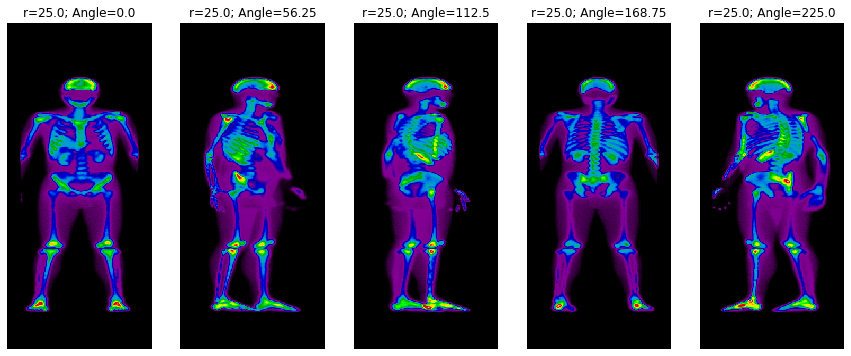

In [17]:
fig, axes = plt.subplots(1,5,figsize=(15,6))
for i, proj in enumerate([0,10,20,30,40]):
    axes[i].pcolormesh(projections[0][proj].T, cmap='nipy_spectral')
    axes[i].set_title(f'r={image_meta.radii[proj]}; Angle={image_meta.angles[proj]}')
    axes[i].axis('off')

The `object_meta` gives corresponding metadata about the shape and voxel spacing of the object which is to be constructed.

In [24]:
object_meta.shape

(128, 128, 512)

In [25]:
object_meta.dr

(0.47950000762939454, 0.47950000762939454, 0.47950000762939454)

We can use this information to create an `OSEMNet` object, which will be used for ordered subset expectation maximum reconstruction.

$$f_i^{(n+1)} = \frac{f_i^{(n)}}{\sum_j c_{ij} + \beta \frac{\partial V}{\partial f_r}|_{f_i=f_i^{(n)}}} \sum_j c_{ij}\frac{g_j}{\sum_i c_{ij}f_i^{(n)}} $$

First we need to give all required information for the forward projection operator $\sum_i c_{ij} a_i$ and the back projection operator $\sum_j c_{ij} b_j$ work.

* This amounts to defining the different image correction techniques we want to use. In some cases we'll want to adjust for phenomenon such as attenuation as PSF blurring.

In this initial tutorial, we won't focus on any image correction techniques yet. We can define our forward and back projection nets as follows:

In [29]:
fp_net = ForwardProjectionNet(object_correction_nets=[],
                              image_correction_nets=[],
                              object_meta=object_meta,
                              image_meta=image_meta)
bp_net = BackProjectionNet(object_correction_nets=[],
                           image_correction_nets=[],
                           object_meta=object_meta,
                           image_meta=image_meta)

Projection networks work as follows: `fp_net` converts an object in to an image and `bp_net` converts an image into an object. For example, we can back project our projections we currently have:

In [31]:
object_new = bp_net(projections)

In [32]:
plt.pcolormesh(object_)

torch.Size([1, 128, 128, 512])

With these networks, we can finally create our `OSEMNet`

In [23]:
osem_net = OSEMNet(object_initial=torch,)

TypeError: OSEMNet.__init__() missing 2 required positional arguments: 'forward_projection_net' and 'back_projection_net'

In [22]:
OSEMNet?

Init signature:
OSEMNet(
    object_initial,
    forward_projection_net,
    back_projection_net,
    prior=None,
)
Docstring:     
Network used to run OSEM reconstruction: :math:`f_i^{(n+1)} = \frac{f_i^{(n)}}{\sum_j c_{ij} + \beta \frac{\partial V}{\partial f_r}|_{f_i=f_i^{(n)}}} \sum_j c_{ij}\frac{g_j}{\sum_i c_{ij}f_i^{(n)}}`. Initializer initializes the reconstruction algorithm with the initial object guess :math:`f_i^{(0)}`, forward and back projections used (i.e. networks to compute :math:`\sum_i c_{ij} a_i` and :math:`\sum_j c_{ij} b_j`), and prior for Bayesian corrections. Note that OSEMNet uses the one step late (OSL algorithm to compute priors during reconstruction. Once the class is initialized, the number of iterations and subsets are specified at recon time when the forward method is called.

Args:
    object_initial (torch.tensor[batch_size, Lx, Ly, Lz]): represents the initial object guess :math:`f_i^{(0)}` for the algorithm in object space
    forward_projection_net (F